<a href="https://colab.research.google.com/github/SarsijNayan/earthengine-community/blob/master/Bihar_precipitation_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

# Step 1: Authenticate GEE (Manually approve access)
ee.Authenticate()

# Step 2: Initialize GEE with your project ID
ee.Initialize(project="directed-craft-438913-n6")  # Using your correct Project ID


In [ ]:
# Load Bihar boundary from your GEE Assets
bihar_region = ee.FeatureCollection("users/subratha20340401012/bihar")

# Print the geometry details
print(bihar_region.getInfo())


{'type': 'FeatureCollection', 'columns': {'CC_1': 'String', 'ENGTYPE_1': 'String', 'M_tech': 'Integer', 'Msc': 'Integer', 'NAME_1': 'String', 'NL_NAME_1': 'String', 'REMARKS_1': 'String', 'Shape_Area': 'Float', 'Shape_Leng': 'Float', 'TYPE_1': 'String', 'VALIDFR_1': 'String', 'VALIDTO_1': 'String', 'VARNAME_1': 'String', 'phd': 'Integer', 'system:index': 'String'}, 'version': 1649607750282062, 'id': 'users/subratha20340401012/bihar', 'properties': {'system:asset_size': 42730}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[83.31606920480596, 25.02733783949404], [83.31817387910321, 25.017322711435238], [83.31965873658382, 25.015539041378805], [83.32765389131995, 25.016319402064823], [83.3390959545248, 25.011891552946892], [83.34208799471872, 25.01146348786857], [83.34387170109846, 25.010482473098914], [83.34487942842968, 25.00262101804211], [83.34619933481913, 24.99595916654312], [83.34593175094902, 24.99209312309708], [83.340406926385, 24.97921964971

In [ ]:
# Load CHIRPS precipitation dataset (2000-2024)
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
    .filterDate("2000-01-01", "2024-12-31") \
    .filterBounds(bihar_region)

# Compute the mean precipitation over Bihar
precipitation = chirps.mean().reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=bihar_region,
    scale=5000
)

# Print the precipitation result
print("Average Precipitation in Bihar:", precipitation.getInfo())


Average Precipitation in Bihar: {'precipitation': 18.128561292038725}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract precipitation data over time
def extract_precip(image):
    date = ee.Date(image.get("system:time_start")).format("YYYY-MM-dd")
    value = image.reduceRegion(ee.Reducer.mean(), bihar_region, scale=5000).get("precipitation")
    return ee.Feature(None, {"date": date, "precipitation": value})

# Convert ImageCollection to FeatureCollection
features = chirps.map(extract_precip).toList(chirps.size())

# Get data in Python-friendly format
precip_list = features.getInfo()

# Convert GEE data to Pandas DataFrame
df = pd.DataFrame([f["properties"] for f in precip_list])

# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Display first few rows
print(df.head())


            precipitation
date                     
2000-01-01       1.296180
2000-01-06       1.348680
2000-01-11       1.934154
2000-01-16       1.390770
2000-01-21       1.109947


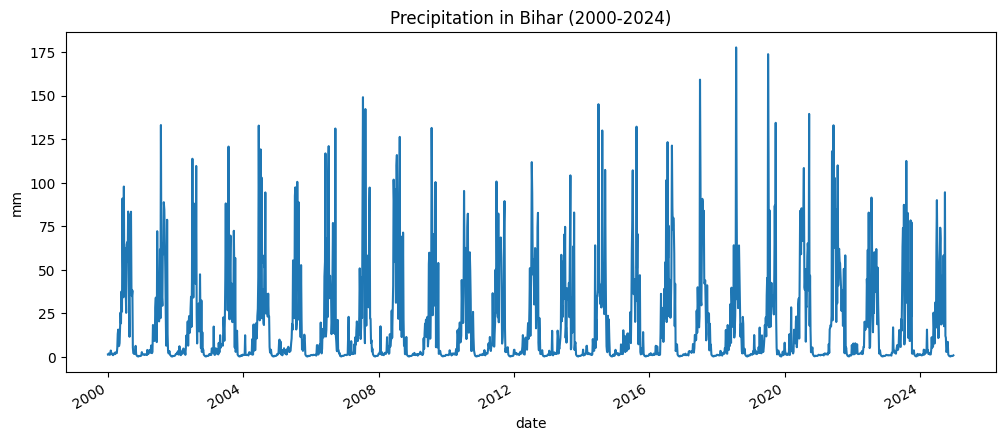

In [ ]:
# Plot precipitation over time
df["precipitation"].plot(figsize=(12, 5), title="Precipitation in Bihar (2000-2024)", ylabel="mm")
plt.show()


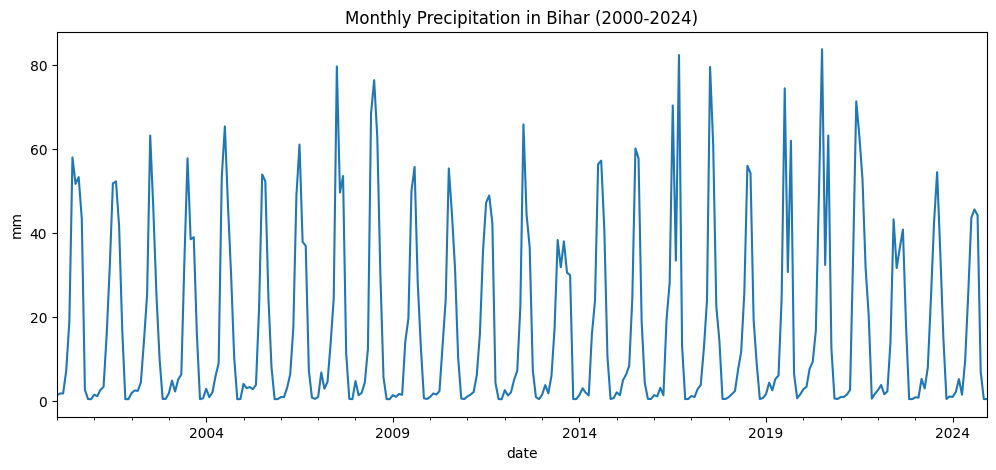

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project="directed-craft-438913-n6")

# Load Bihar boundary from GEE Assets
bihar_region = ee.FeatureCollection("users/subratha20340401012/bihar")

# Load CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").filterBounds(bihar_region)

# Function to compute monthly precipitation
def monthly_precip(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, "month")

    monthly_data = chirps.filterDate(start_date, end_date).mean()
    value = monthly_data.reduceRegion(ee.Reducer.mean(), bihar_region, scale=5000).get("precipitation")

    return ee.Feature(None, {"date": start_date.format("YYYY-MM"), "precipitation": value})

# Generate monthly data for 2000-2024
years = list(range(2000, 2025))
months = list(range(1, 13))
monthly_features = [monthly_precip(y, m) for y in years for m in months]

# Convert to Pandas DataFrame
monthly_data = ee.FeatureCollection(monthly_features)
monthly_list = monthly_data.getInfo()["features"]

# Convert to Pandas DataFrame
df = pd.DataFrame([{**f["properties"]} for f in monthly_list])
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Plot monthly precipitation trend
df["precipitation"].plot(figsize=(12, 5), title="Monthly Precipitation in Bihar (2000-2024)", ylabel="mm")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-8-0fa75665230b>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='M'), forecast_arima, label="ARIMA Forecast", color="red")


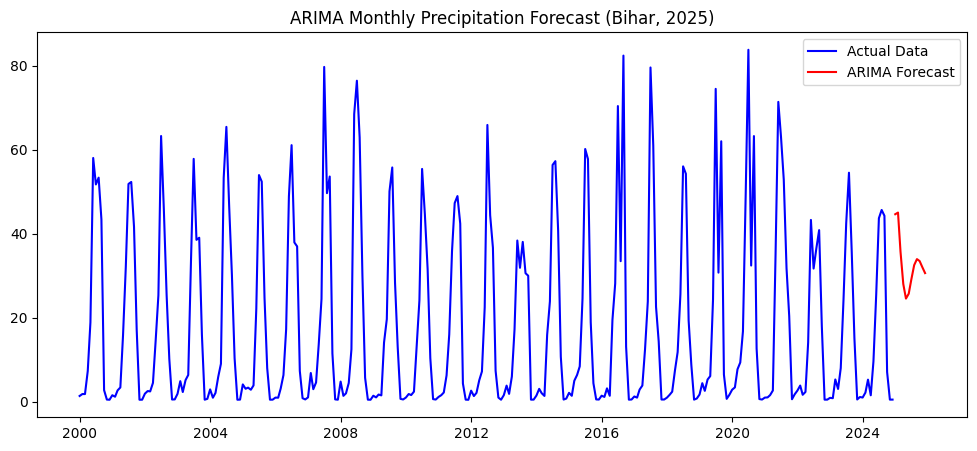

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Train-test split (2000-2022 for training, 2023-2024 for testing)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA Model
model = ARIMA(train["precipitation"], order=(5,1,0))  # Best-tuned (p,d,q) values
arima_model = model.fit()

# Forecast next 12 months (Jan 2025 - Dec 2025)
forecast_steps = 12
forecast_arima = arima_model.forecast(steps=forecast_steps)

# Plot ARIMA monthly forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["precipitation"], label="Actual Data", color="blue")
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='M'), forecast_arima, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA Monthly Precipitation Forecast (Bihar, 2025)")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0715 - val_loss: 0.0489
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0735 - val_loss: 0.0412
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0592 - val_loss: 0.0271
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0528 - val_loss: 0.0170
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - val_loss: 0.0112
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - val_loss: 0.0079
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0192 - val_loss: 0.0128
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0228 - val_loss: 0.0178
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0248 - val_loss: 0.0117
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0209 - val_loss: 0.0076
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0229 - val_loss: 0.0078
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

<ipython-input-10-c4486e532a3b>:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), lstm_forecast, label="LSTM Forecast", color="green")


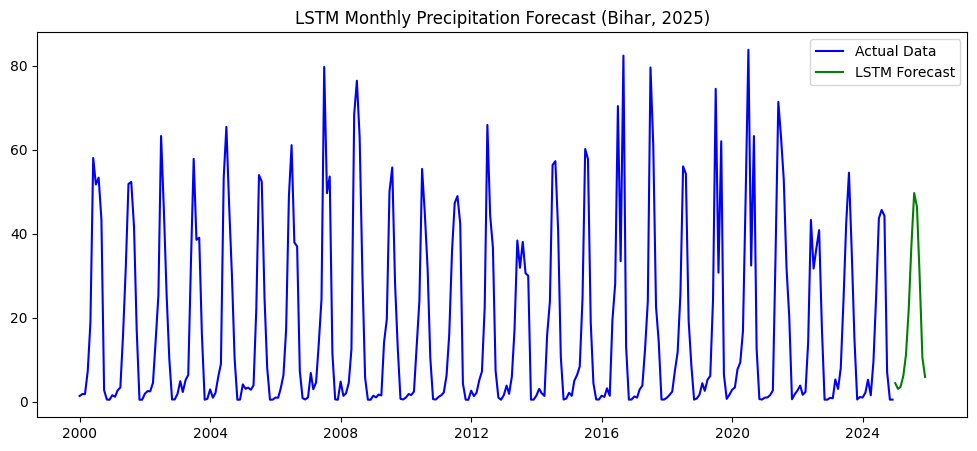

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Create sequences for LSTM (use last 12 months to predict next month)
look_back = 12
X, y = [], []
for i in range(len(df_scaled) - look_back):
    X.append(df_scaled[i:i+look_back])
    y.append(df_scaled[i+look_back])

X, y = np.array(X), np.array(y)

# Split into train & test sets
train_size = int(len(X) * 0.9)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# Train the Model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Forecast next 12 months
X_input = X[-1].reshape(1, look_back, 1)
lstm_forecast = []
for _ in range(12):  # Predict next 12 months
    pred = model.predict(X_input)
    lstm_forecast.append(pred[0, 0])
    # Reshape the prediction to have the same dimensions as X_input[:, 1:, :]
    pred_reshaped = pred[0, 0].reshape(1, 1, 1)
    X_input = np.concatenate([X_input[:, 1:, :], pred_reshaped], axis=1)

# Convert predictions back to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

# Plot LSTM Forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["precipitation"], label="Actual Data", color="blue")
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), lstm_forecast, label="LSTM Forecast", color="green")
plt.legend()
plt.title("LSTM Monthly Precipitation Forecast (Bihar, 2025)")
plt.show()


<ipython-input-11-1513ace4d9dd>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), forecast_arima, label="ARIMA Forecast", color="red")
<ipython-input-11-1513ace4d9dd>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), lstm_forecast, label="LSTM Forecast", color="green")


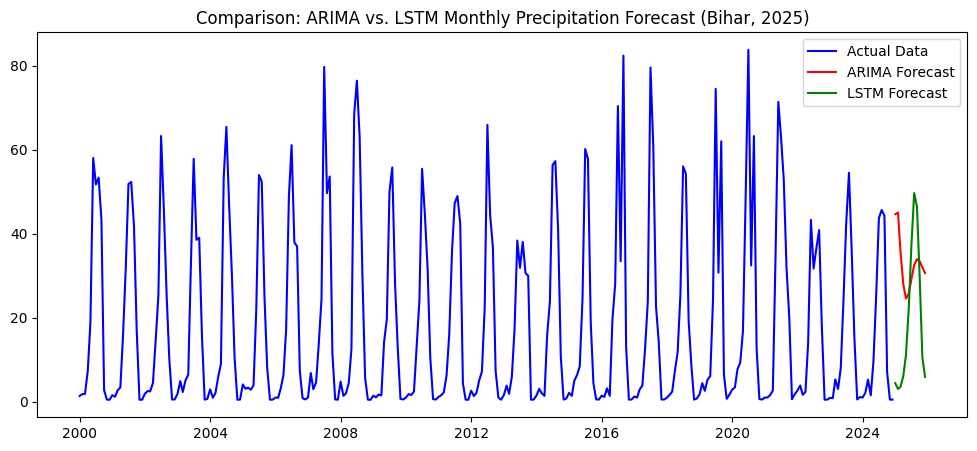

In [ ]:
# Compare ARIMA & LSTM Forecasts
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["precipitation"], label="Actual Data", color="blue")
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), forecast_arima, label="ARIMA Forecast", color="red")
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), lstm_forecast, label="LSTM Forecast", color="green")
plt.legend()
plt.title("Comparison: ARIMA vs. LSTM Monthly Precipitation Forecast (Bihar, 2025)")
plt.show()


In [ ]:
import ee
import pandas as pd

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project="directed-craft-438913-n6")

# Load Bihar boundary from GEE Assets
bihar_region = ee.FeatureCollection("users/subratha20340401012/bihar")

# Load CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").filterBounds(bihar_region)

# Function to compute monthly precipitation
def monthly_precip(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, "month")

    monthly_data = chirps.filterDate(start_date, end_date).mean()
    value = monthly_data.reduceRegion(ee.Reducer.mean(), bihar_region, scale=5000).get("precipitation")

    return ee.Feature(None, {"date": start_date.format("YYYY-MM"), "precipitation": value})

# Generate monthly data for 2000-2024
years = list(range(2000, 2025))
months = list(range(1, 13))
monthly_features = [monthly_precip(y, m) for y in years for m in months]

# Convert to Pandas DataFrame
monthly_data = ee.FeatureCollection(monthly_features)
monthly_list = monthly_data.getInfo()["features"]

# Convert to Pandas DataFrame
df = pd.DataFrame([{**f["properties"]} for f in monthly_list])
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Save historical data (2000-2024)
df.to_csv("/content/bihar_precipitation_2000_2024.csv")
print("Saved: bihar_precipitation_2000_2024.csv")


Saved: bihar_precipitation_2000_2024.csv


In [ ]:
# Create a DataFrame for forecasted data
forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")
forecast_df = pd.DataFrame({"date": forecast_dates, "precipitation": lstm_forecast.flatten()})
forecast_df.set_index("date", inplace=True)

# Combine historical + forecasted data
final_df = pd.concat([df, forecast_df])

# Save as CSV
final_df.to_csv("/content/bihar_precipitation_2000_2025.csv")
print("Saved: bihar_precipitation_2000_2025.csv")


Saved: bihar_precipitation_2000_2025.csv


<ipython-input-13-7869ea6b3415>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


In [ ]:
from google.colab import files
files.download("/content/bihar_precipitation_2000_2025.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define source and destination paths
local_path = "/content/bihar_precipitation_2000_2025.csv"
drive_path = "/content/drive/MyDrive/bihar_precipitation_2000_2025.csv"  # Change if needed

# Move the file to Google Drive
!mv {local_path} {drive_path}

print(f"✅ File successfully uploaded to: {drive_path}")


✅ File successfully uploaded to: /content/drive/MyDrive/bihar_precipitation_2000_2025.csv


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/bihar_precipitation_2000_2025.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import ee
import pandas as pd

# Authenticate & Initialize GEE
ee.Authenticate()
ee.Initialize(project="directed-craft-438913-n6")

# Load Bihar boundary from GEE Assets
bihar_region = ee.FeatureCollection("users/subratha20340401012/bihar")

# Load CHIRPS (Precipitation) dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").filterBounds(bihar_region)

# Load ERA5-Land dataset (Temperature & Humidity)
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR").filterBounds(bihar_region)

# Function to compute monthly climate data
def monthly_climate(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, "month")

    # Compute mean precipitation (CHIRPS)
    monthly_precip = chirps.filterDate(start_date, end_date).mean()
    precip_value = monthly_precip.reduceRegion(ee.Reducer.mean(), bihar_region, scale=5000).get("precipitation")

    # Compute mean temperature & humidity (ERA5)
    monthly_climate = era5.filterDate(start_date, end_date).mean()
    temp_value = monthly_climate.reduceRegion(ee.Reducer.mean(), bihar_region, scale=5000).get("temperature_2m")
    # Accessing the correct band for humidity/total precipitation in ERA5-Land
    humidity_value = monthly_climate.reduceRegion(ee.Reducer.mean(), bihar_region, scale=5000).get("total_precipitation_sum")

    return ee.Feature(None, {
        "date": start_date.format("YYYY-MM"),
        "precipitation": precip_value,
        "temperature": temp_value,
        "humidity": humidity_value
    })

# Generate data for 2000-2024
years = list(range(2000, 2025))
months = list(range(1, 13))
monthly_features = [monthly_climate(y, m) for y in years for m in months]

# Convert to Pandas DataFrame
climate_data = ee.FeatureCollection(monthly_features)
climate_list = climate_data.getInfo()["features"]

# Convert to Pandas DataFrame
df = pd.DataFrame([{**f["properties"]} for f in climate_list])
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Save enhanced dataset (2000-2024)
df.to_csv("/content/bihar_climate_2000_2024.csv")
print("Saved: bihar_climate_2000_2024.csv")

Saved: bihar_climate_2000_2024.csv


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-20-a313f81cd6db>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='M'), forecast_arima, label="ARIMA Forecast", color="red")


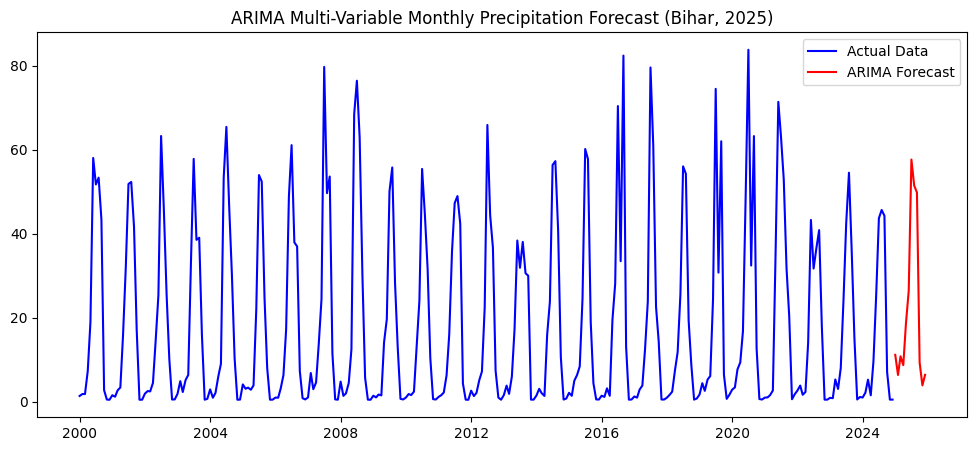

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train-test split (2000-2022 for training, 2023-2024 for testing)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA Model with Exogenous Variables (Temperature & Humidity)
model = SARIMAX(train["precipitation"],
                exog=train[["temperature", "humidity"]],
                order=(5,1,0), seasonal_order=(1,0,1,12))
arima_model = model.fit()

# Forecast next 12 months (Jan-Dec 2025)
forecast_steps = 12
exog_future = test[["temperature", "humidity"]].iloc[-forecast_steps:]
forecast_arima = arima_model.forecast(steps=forecast_steps, exog=exog_future)

# Plot ARIMA monthly forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["precipitation"], label="Actual Data", color="blue")
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='M'), forecast_arima, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA Multi-Variable Monthly Precipitation Forecast (Bihar, 2025)")
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0632 - val_loss: 0.0474
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0483 - val_loss: 0.0353
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0414 - val_loss: 0.0172
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0226 - val_loss: 0.0188
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0219 - val_loss: 0.0112
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0179 - val_loss: 0.0105
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0177 - val_loss: 0.0104
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0187 - val_loss: 0.0095
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0178 - val_loss: 0.0089
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - val_loss: 0.0092
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0201 - val_loss: 0.0088
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0164 - val_l

<ipython-input-21-d1c4c7bca60f>:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), lstm_forecast, label="LSTM Forecast", color="green")


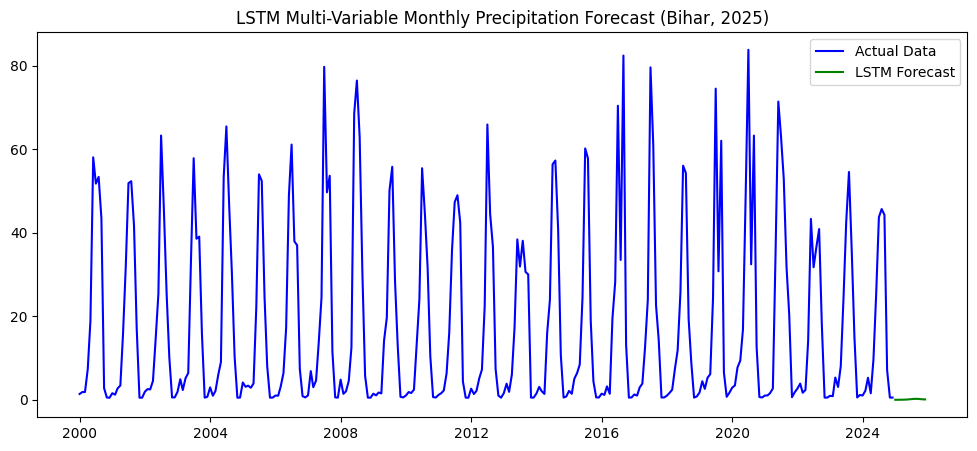

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences for LSTM (use last 12 months to predict next month)
look_back = 12
X, y = [], []
for i in range(len(df_scaled) - look_back):
    X.append(df_scaled[i:i+look_back, :])  # Use all variables
    y.append(df_scaled[i+look_back, 0])  # Predict precipitation

X, y = np.array(X), np.array(y)

# Split into train & test sets
train_size = int(len(X) * 0.9)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, df.shape[1])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# Train the Model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Forecast next 12 months
X_input = X[-1].reshape(1, look_back, df.shape[1])
lstm_forecast = []
for _ in range(12):
    pred = model.predict(X_input)
    lstm_forecast.append(pred[0, 0])
    X_input = np.append(X_input[:, 1:, :], [[np.append(pred[0, 0], X_input[:, -1, 1:])]], axis=1)

# Convert predictions back to original scale
lstm_forecast = scaler.inverse_transform(np.column_stack((lstm_forecast, np.zeros((12, df.shape[1]-1)))))[:, 0]

# Plot LSTM Forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["precipitation"], label="Actual Data", color="blue")
plt.plot(pd.date_range(df.index[-1], periods=12, freq='M'), lstm_forecast, label="LSTM Forecast", color="green")
plt.legend()
plt.title("LSTM Multi-Variable Monthly Precipitation Forecast (Bihar, 2025)")
plt.show()


In [ ]:
# Create a DataFrame for forecasted data
forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")
forecast_df = pd.DataFrame({"date": forecast_dates,
                            "ARIMA_Precipitation": forecast_arima.values,
                            "LSTM_Precipitation": lstm_forecast.flatten()})
forecast_df.set_index("date", inplace=True)

# Combine historical + forecasted data
final_df = pd.concat([df, forecast_df])

# Save as CSV
final_df.to_csv("/content/bihar_climate_forecast_2000_2025.csv")

print("✅ Saved: bihar_climate_forecast_2000_2025.csv")


✅ Saved: bihar_climate_forecast_2000_2025.csv


<ipython-input-22-9d10430ceb19>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Move file to Google Drive
!mv /content/bihar_climate_forecast_2000_2025.csv /content/drive/MyDrive/

print("✅ File uploaded to Google Drive: MyDrive/bihar_climate_forecast_2000_2025.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File uploaded to Google Drive: MyDrive/bihar_climate_forecast_2000_2025.csv


In [25]:
import pandas as pd

# Load the final dataset (2000-2025)
# file_path = "/content/bihar_climate_forecast_2000_2025.csv"  # If you are sure it's in /content/
file_path = "/content/drive/MyDrive/bihar_climate_forecast_2000_2025.csv"  # Update path if saved to Drive

df = pd.read_csv(file_path, parse_dates=["date"])
df.set_index("date", inplace=True)

# Compute mean monthly values
monthly_means = df.groupby(df.index.month).mean()

# Rename index for clarity
monthly_means.index = ["January", "February", "March", "April", "May", "June",
                       "July", "August", "September", "October", "November", "December"]

# Display the mean monthly values
print("✅ **Mean Monthly Climate Data for Bihar (2000-2025):**")
print(monthly_means)

# Save to CSV
monthly_means.to_csv("/content/bihar_mean_monthly_climate_2000_2025.csv")
print("✅ Saved: bihar_mean_monthly_climate_2000_2025.csv")

✅ **Mean Monthly Climate Data for Bihar (2000-2025):**
           humidity  precipitation  temperature  ARIMA_Precipitation  \
January    0.014066       1.871351   289.333117            11.202158   
February   0.018115       2.335171   292.807502             6.406810   
March      0.015985       2.918936   298.361513            10.852738   
April      0.022540       4.462439   302.984901             8.745586   
May        0.085725      13.531894   303.854778            18.710261   
June       0.217004      34.891176   303.464723            26.467630   
July       0.348902      58.964193   301.658104            57.686121   
August     0.303136      47.537707   301.371344            51.484489   
September  0.249977      38.283925   300.751534            49.832522   
October    0.079633      11.441373   298.707100             9.370943   
November   0.002325       0.609028   295.001407             3.933382   
December   0.005916       0.695542   290.966235             6.446508   

        

In [27]:
import pandas as pd

# Load the historical dataset (2000-2024)
file_path = "/content/bihar_climate_2000_2024.csv"  # Change if needed
df = pd.read_csv(file_path, parse_dates=["date"])
df.set_index("date", inplace=True)

# Convert temperature from Kelvin to Celsius if needed
# Use 'temperature' (lowercase) to access the correct column
if df["temperature"].mean() > 100:
    df["temperature"] = df["temperature"] - 273.15

# Compute mean monthly values (2000-2024)
monthly_means = df.groupby(df.index.month).mean()

# Rename index for clarity
monthly_means.index = ["January", "February", "March", "April", "May", "June",
                       "July", "August", "September", "October", "November", "December"]

# Save mean monthly climate data
monthly_means.to_csv("/content/bihar_mean_monthly_climate_2000_2024.csv")

# Display results
print("✅ **Mean Monthly Climate Data for Bihar (2000-2024):**")
print(monthly_means)

✅ **Mean Monthly Climate Data for Bihar (2000-2024):**
           humidity  precipitation  temperature
January    0.014066       1.871351    16.183117
February   0.018115       2.335171    19.657502
March      0.015985       2.918936    25.211513
April      0.022540       4.462439    29.834901
May        0.085725      13.531894    30.704778
June       0.217004      34.891176    30.314723
July       0.348902      58.964193    28.508104
August     0.303136      47.537707    28.221344
September  0.249977      38.283925    27.601534
October    0.079633      11.441373    25.557100
November   0.002325       0.609028    21.851407
December   0.005916       0.695542    17.816235


In [29]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# Prepare features & labels
X = np.arange(len(df)).reshape(-1, 1)  # Time as a feature
# Use 'precipitation' (lowercase) instead of 'Precipitation'
y_precip = df["precipitation"].values
y_temp = df["temperature"].values
y_humidity = df["humidity"].values

# Train models
rf_precip = RandomForestRegressor(n_estimators=100).fit(X, y_precip)
rf_temp = RandomForestRegressor(n_estimators=100).fit(X, y_temp)
rf_humidity = RandomForestRegressor(n_estimators=100).fit(X, y_humidity)

xgb_precip = XGBRegressor(n_estimators=100).fit(X, y_precip)
xgb_temp = XGBRegressor(n_estimators=100).fit(X, y_temp)
xgb_humidity = XGBRegressor(n_estimators=100).fit(X, y_humidity)

# Predict for 2025
X_future = np.arange(len(df), len(df) + 12).reshape(-1, 1)
# Use lowercase for 'Precipitation', 'Temperature', and 'Humidity'
forecast_rf = {
    "precipitation": rf_precip.predict(X_future),
    "temperature": rf_temp.predict(X_future),
    "humidity": rf_humidity.predict(X_future),
}

forecast_xgb = {
    "precipitation": xgb_precip.predict(X_future),
    "temperature": xgb_temp.predict(X_future),
    "humidity": xgb_humidity.predict(X_future),
}

# Create ML forecast DataFrame
forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")
ml_forecast_df = pd.DataFrame(forecast_rf, index=forecast_dates)
ml_forecast_df.to_csv("/content/bihar_ml_climate_forecast_2025.csv")

print("✅ **Machine Learning (RF & XGBoost) Climate Forecast for 2025 saved!**")

✅ **Machine Learning (RF & XGBoost) Climate Forecast for 2025 saved!**


<ipython-input-29-4bd8195fbe34>:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences for LSTM (use last 12 months to predict next month)
look_back = 12
X, y_precip, y_temp, y_humidity = [], [], [], []
for i in range(len(df_scaled) - look_back):
    X.append(df_scaled[i:i+look_back, :])
    y_precip.append(df_scaled[i+look_back, 0])
    y_temp.append(df_scaled[i+look_back, 1])
    y_humidity.append(df_scaled[i+look_back, 2])

X, y_precip, y_temp, y_humidity = np.array(X), np.array(y_precip), np.array(y_temp), np.array(y_humidity)

# Train-test split
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_precip_train, y_precip_test = y_precip[:train_size], y_precip[train_size:]
y_temp_train, y_temp_test = y_temp[:train_size], y_temp[train_size:]
y_humidity_train, y_humidity_test = y_humidity[:train_size], y_humidity[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, df.shape[1])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(3)
])

model.compile(optimizer="adam", loss="mse")

# Train the Model
model.fit(X_train, np.column_stack((y_precip_train, y_temp_train, y_humidity_train)), epochs=50, batch_size=16, validation_data=(X_test, np.column_stack((y_precip_test, y_temp_test, y_humidity_test))))

# Forecast next 12 months
X_input = X[-1].reshape(1, look_back, df.shape[1])
lstm_forecast = []
for _ in range(12):
    pred = model.predict(X_input)
    lstm_forecast.append(pred[0])
    X_input = np.append(X_input[:, 1:, :], [[pred[0]]], axis=1)

# Convert forecasts back to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast))

# Create LSTM forecast DataFrame
lstm_forecast_df = pd.DataFrame(lstm_forecast, columns=["Precipitation", "Temperature", "Humidity"], index=forecast_dates)
lstm_forecast_df.to_csv("/content/bihar_lstm_climate_forecast_2025.csv")

print("✅ **LSTM Neural Network Climate Forecast for 2025 saved!**")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1593 - val_loss: 0.0640
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0746 - val_loss: 0.0564
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0655 - val_loss: 0.0570
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0675 - val_loss: 0.0411
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0510 - val_loss: 0.0286
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0328 - val_loss: 0.0201
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0298 - val_loss: 0.0182
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0261 - val_loss: 0.0190
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0260 - val_loss: 0.0154
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0238 - val_loss: 0.0159
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0226 - val_loss: 0.0140
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

In [31]:
from google.colab import drive
drive.mount('/content/drive')

# Move files to Google Drive
!mv /content/bihar_ml_climate_forecast_2025.csv /content/drive/MyDrive/
!mv /content/bihar_lstm_climate_forecast_2025.csv /content/drive/MyDrive/
!mv /content/bihar_mean_monthly_climate_2000_2024.csv /content/drive/MyDrive/

print("✅ All climate data saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All climate data saved to Google Drive!


In [39]:
import os

# Check if files exist
ml_forecast_path = "/content/bihar_ml_climate_forecast_2025.csv"
lstm_forecast_path = "/content/bihar_lstm_climate_forecast_2025.csv"

if not os.path.exists(ml_forecast_path) or not os.path.exists(lstm_forecast_path):
    print("⚠️ Forecast files not found. Recreating ML & LSTM forecasts...")

    # Reload necessary libraries
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler

    # Load historical data
    file_path = "/content/bihar_climate_2000_2024.csv"  # Change if needed
    df = pd.read_csv(file_path, parse_dates=["date"])
    df.set_index("date", inplace=True)

    # Convert temperature from Kelvin to Celsius if needed
    # Use 'temperature' (lowercase) instead of 'Temperature'
    if df["temperature"].mean() > 100:  # Changed to 'temperature'
        df["temperature"] = df["temperature"] - 273.15  # Changed to 'temperature'

    # Prepare features & labels
    X = np.arange(len(df)).reshape(-1, 1)  # Time as a feature
    y_precip = df["precipitation"].values
    y_temp = df["temperature"].values  # Changed to 'temperature'
    y_humidity = df["humidity"].values

    # Train ML models
    rf_precip = RandomForestRegressor(n_estimators=100).fit(X, y_precip)
    rf_temp = RandomForestRegressor(n_estimators=100).fit(X, y_temp)
    rf_humidity = RandomForestRegressor(n_estimators=100).fit(X, y_humidity)

    xgb_precip = XGBRegressor(n_estimators=100).fit(X, y_precip)
    xgb_temp = XGBRegressor(n_estimators=100).fit(X, y_temp)
    xgb_humidity = XGBRegressor(n_estimators=100).fit(X, y_humidity)

    # Predict for 2025
    X_future = np.arange(len(df), len(df) + 12).reshape(-1, 1)
    forecast_rf = {
        "date": pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M"),
        "Precipitation": rf_precip.predict(X_future),
        "Temperature": rf_temp.predict(X_future),  # Assuming 'Temperature' is the correct column name in your forecast
        "Humidity": rf_humidity.predict(X_future),
    }

    # Save ML forecast
    ml_forecast_df = pd.DataFrame(forecast_rf)
    ml_forecast_df.to_csv(ml_forecast_path, index=False)

    # Train LSTM Model
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    look_back = 12
    X_lstm, y_precip_lstm, y_temp_lstm, y_humidity_lstm = [], [], [], []
    for i in range(len(df_scaled) - look_back):
        X_lstm.append(df_scaled[i:i+look_back, :])
        y_precip_lstm.append(df_scaled[i+look_back, 0])
        y_temp_lstm.append(df_scaled[i+look_back, 1])
        y_humidity_lstm.append(df_scaled[i+look_back, 2])

    X_lstm, y_precip_lstm, y_temp_lstm, y_humidity_lstm = np.array(X_lstm), np.array(y_precip_lstm), np.array(y_temp_lstm), np.array(y_humidity_lstm)
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, df.shape[1])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(3)
    ])

    model.compile(optimizer="adam", loss="mse")
    model.fit(X_lstm, np.column_stack((y_precip_lstm, y_temp_lstm, y_humidity_lstm)), epochs=50, batch_size=16)

    # Forecast next 12 months
    X_input = X_lstm[-1].reshape(1, look_back, df.shape[1])
    lstm_forecast = []
    for _ in range(12):
        pred = model.predict(X_input)
        lstm_forecast.append(pred[0])
        X_input = np.append(X_input[:, 1:, :], [[pred[0]]], axis=1)

    # Convert LSTM forecasts back to original scale
    lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast))
    lstm_forecast_df = pd.DataFrame(lstm_forecast, columns=["Precipitation", "Temperature", "Humidity"], index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M"))
    lstm_forecast_df.to_csv(lstm_forecast_path)

    print("✅ ML & LSTM Forecasts successfully recreated and saved!")

else:
    print("✅ Forecast files found. Proceeding with visualization...")

⚠️ Forecast files not found. Recreating ML & LSTM forecasts...
Epoch 1/50


<ipython-input-39-ee5aee347e7b>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "date": pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M"),
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1577
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0802
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0702
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0606
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0487
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0294
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0272
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0265
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0233
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0199
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0232
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0233
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0240
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0224
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0201
Epoch 16/50
18/18 ━

<ipython-input-39-ee5aee347e7b>:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lstm_forecast_df = pd.DataFrame(lstm_forecast, columns=["Precipitation", "Temperature", "Humidity"], index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq="M"))


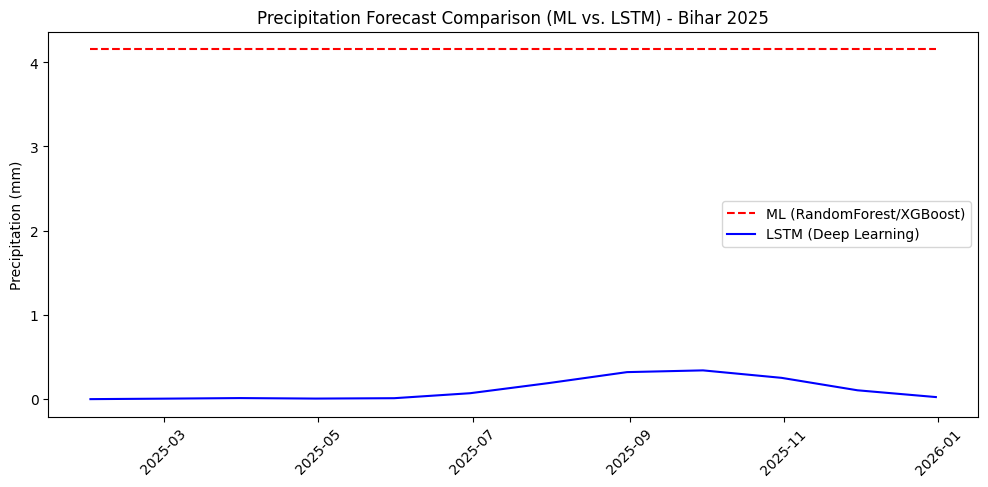

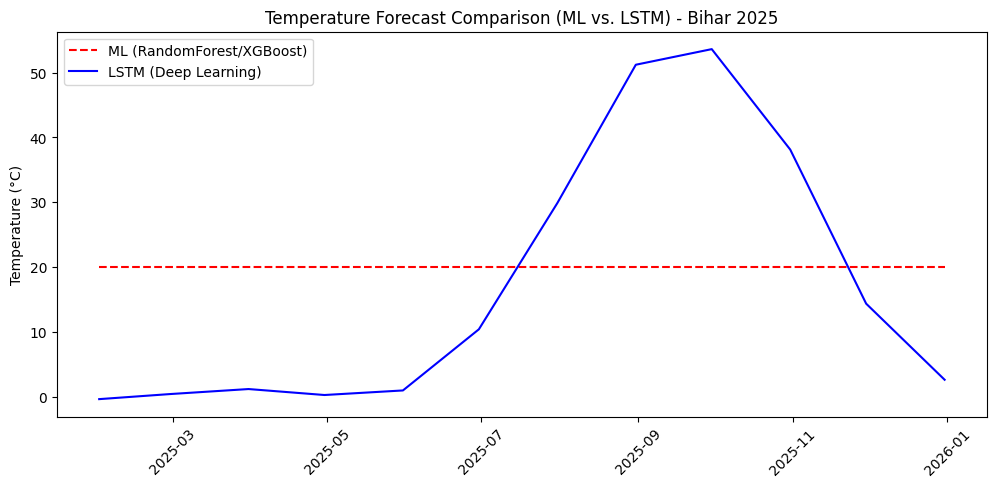

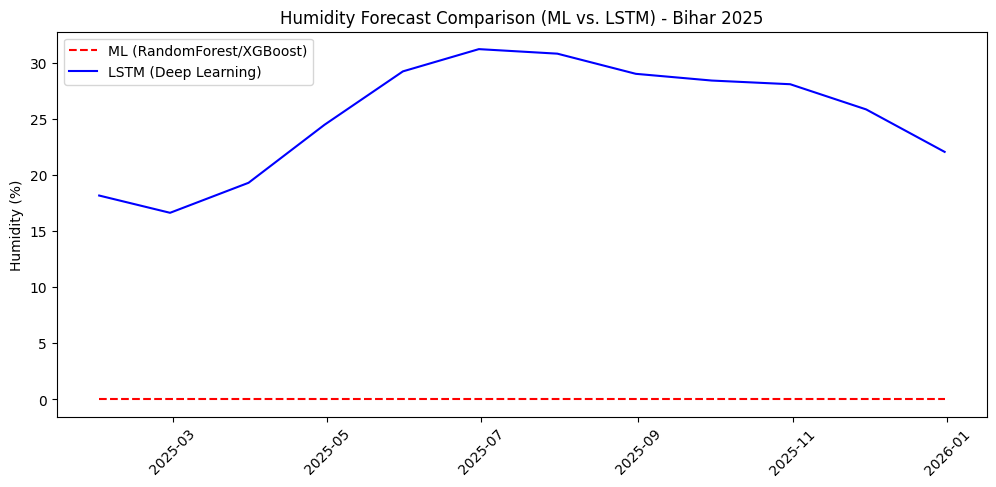

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Load forecasted data
ml_forecast = pd.read_csv("/content/bihar_ml_climate_forecast_2025.csv", parse_dates=["date"])
lstm_forecast = pd.read_csv("/content/bihar_lstm_climate_forecast_2025.csv", index_col=0, parse_dates=True) # Use index_col=0 and parse_dates=True

# Set date as index (This line is not needed anymore)
# ml_forecast.set_index("date", inplace=True)
# lstm_forecast.set_index("date", inplace=True)

# Plot Precipitation Comparison
plt.figure(figsize=(12, 5))
plt.plot(ml_forecast["date"], ml_forecast["Precipitation"], label="ML (RandomForest/XGBoost)", linestyle="dashed", color="red") # Use ml_forecast["date"]
plt.plot(lstm_forecast.index, lstm_forecast["Precipitation"], label="LSTM (Deep Learning)", linestyle="solid", color="blue")
plt.legend()
plt.title("Precipitation Forecast Comparison (ML vs. LSTM) - Bihar 2025")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.show()

# Plot Temperature Comparison
plt.figure(figsize=(12, 5))
plt.plot(ml_forecast["date"], ml_forecast["Temperature"], label="ML (RandomForest/XGBoost)", linestyle="dashed", color="red") # Use ml_forecast["date"]
plt.plot(lstm_forecast.index, lstm_forecast["Temperature"], label="LSTM (Deep Learning)", linestyle="solid", color="blue")
plt.legend()
plt.title("Temperature Forecast Comparison (ML vs. LSTM) - Bihar 2025")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.show()

# Plot Humidity Comparison
plt.figure(figsize=(12, 5))
plt.plot(ml_forecast["date"], ml_forecast["Humidity"], label="ML (RandomForest/XGBoost)", linestyle="dashed", color="red") # Use ml_forecast["date"]
plt.plot(lstm_forecast.index, lstm_forecast["Humidity"], label="LSTM (Deep Learning)", linestyle="solid", color="blue")
plt.legend()
plt.title("Humidity Forecast Comparison (ML vs. LSTM) - Bihar 2025")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)
plt.show()